# Import Important Library

In [2]:
import pandas as pd #for reaed data
import re #for text cleansing

#visualization
import matplotlib.pyplot as plt
import seaborn as sns 

# EDA

## Read Data

In [3]:
dfText = pd.read_csv('dataset/train_preprocess.tsv', sep='\t', names=['text', 'label'])
dfText.head()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


## Check Info Data

In [4]:
len(dfText)

11000

In [17]:
dfText.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11000 non-null  object
 1   label   11000 non-null  object
dtypes: object(2)
memory usage: 172.0+ KB


In [18]:
dfText.isnull().sum()

text     0
label    0
dtype: int64

## Check Jumlah Label

<BarContainer object of 3 artists>

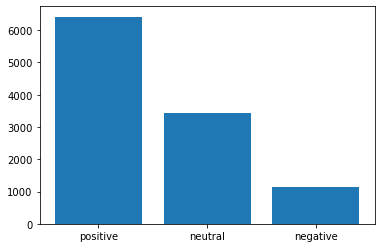

In [13]:
plt.bar(dfText['label'].unique(), dfText['label'].value_counts())